### U-Net For Bio-Medical Images

#### Imports

In [1]:
import os
import pydot
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.utils import plot_model
%load_ext tensorboard

#### Building Simple U-Net Model using VGG19

In [2]:
input_shape = (128, 128, 3)
input_data = tf.keras.layers.Input(input_shape)

In [5]:
normalized_input_data = tf.keras.layers.Lambda(lambda x: x / 255)(input_data)

##### Contraction Path

In [7]:
downsample_1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(normalized_input_data)
downsample_1 = tf.keras.layers.Dropout(0.1)(downsample_1)
downsample_1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(downsample_1)
pooling_1 = tf.keras.layers.MaxPooling2D((2, 2))(downsample_1)

downsample_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pooling_1)
downsample_2 = tf.keras.layers.Dropout(0.1)(downsample_2)
downsample_2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(downsample_2)
pooling_2 = tf.keras.layers.MaxPooling2D((2, 2))(downsample_2)
 
downsample_3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pooling_2)
downsample_3 = tf.keras.layers.Dropout(0.2)(downsample_3)
downsample_3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(downsample_3)
pooling_3 = tf.keras.layers.MaxPooling2D((2, 2))(downsample_3)
 
downsample_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pooling_3)
downsample_4 = tf.keras.layers.Dropout(0.2)(downsample_4)
downsample_4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(downsample_4)
pooling_4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(downsample_4)
 
downsample_5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pooling_4)
downsample_5 = tf.keras.layers.Dropout(0.3)(downsample_5)
downsample_5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(downsample_5)

##### Expansion Path

In [8]:
upsample_6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(downsample_5)
upsample_6 = tf.keras.layers.concatenate([upsample_6, downsample_4])
contraction_6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsample_6)
contraction_6 = tf.keras.layers.Dropout(0.2)(contraction_6)
contraction_6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(contraction_6)
 
upsample_7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(contraction_6)
upsample_7 = tf.keras.layers.concatenate([upsample_7, downsample_3])
contraction_7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsample_7)
contraction_7 = tf.keras.layers.Dropout(0.2)(contraction_7)
contraction_7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(contraction_7)
 
upsample_8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(contraction_7)
upsample_8 = tf.keras.layers.concatenate([upsample_8, downsample_2])
contraction_8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsample_8)
contraction_8 = tf.keras.layers.Dropout(0.1)(contraction_8)
contraction_8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(contraction_8)
 
upsample_9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(contraction_8)
upsample_9 = tf.keras.layers.concatenate([upsample_9, downsample_1], axis=3)
contraction_9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsample_9)
contraction_9 = tf.keras.layers.Dropout(0.1)(contraction_9)
contraction_9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(contraction_9)

##### Output

In [9]:
output_data = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(contraction_9) # Pixelwise Labelling

In [10]:
model = tf.keras.Model(inputs=[input_data], outputs=[output_data])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 128, 128, 16) 0           conv2d_6[0][0]                   
______________________________________________________________________________________________

In [8]:
#plot_model(model)

#### Data preparation

In [11]:
seed = 42
np.random.seed = seed

In [12]:
TRAIN_PATH = 'dataset/cell/train/'
TEST_PATH = 'dataset/cell/test/'

In [13]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [14]:
train_ids

['54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12',
 '57d88f45e479ce3821839b2706d667758c63ac769d76800d815c73d2507c1e42',
 '0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93',
 'cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9d3fc0c214a4e5d32bd',
 'dad607a203483439fcbc2acecd0a39fb5e5a94a32a94348f5c802c79cfeb6e7c',
 'f81ca7ee25e733ff37240c34c8e3044d9937bb0166e315952ebde3f237ecb86f',
 '308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722',
 'e49fc2b4f1f39d481a6525225ab3f688be5c87f56884456ad54c953315efae83',
 'af8621ef0db8c26b0bce6385bd5609b584bfd678fcf7a234b8a15e6bb05c15ac',
 '28d33efef218392e79e385906deb88055d94b65ad217de78c07e85476f80f45a',
 '97126a9791f0c1176e4563ad679a301dac27c59011f579e808bbd6e9f4cd1034',
 'b8fdc02d915206bb2564e1f7da962f2b9d9d491b11afa00a76622b7932366480',
 '7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80',
 '2246874c8b5ba218d01ad8153a201ad4660195f3e4c65da6b9d4ccaf82cb7edf',
 'a022908f1b7880838dbc0411e50828e6

In [15]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [16]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [17]:
X_train.shape

(670, 128, 128, 3)

In [18]:
Y_train.shape

(670, 128, 128, 1)

In [38]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

  0%|          | 0/670 [00:00<?, ?it/s]

Resizing training images and masks


100%|██████████| 670/670 [07:42<00:00,  1.45it/s]


In [39]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

  6%|▌         | 4/65 [00:00<00:01, 37.37it/s]

Resizing test images


100%|██████████| 65/65 [00:02<00:00, 22.99it/s]

Done!


#### Data visualization

In [42]:
print("Shape of Input Image: " ,X_train.shape)
print("Shape of Output Image: ", Y_train.shape)

Shape of Input Image:  (670, 128, 128, 3)
Shape of Output Image:  (670, 128, 128, 1)


Input Image


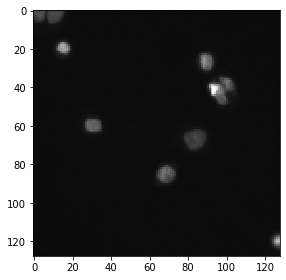

In [43]:
print("Input Image")
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()

Output Image


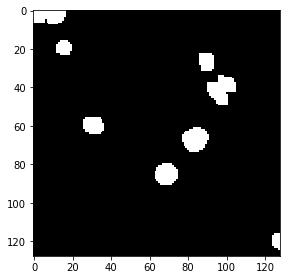

In [45]:
print("Output Image")
imshow(np.squeeze(Y_train[image_x]))
plt.show()

#### Training the model

In [52]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('cell_model.h5', verbose=1, save_best_only=True)

In [53]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [55]:
#model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=1, callbacks=callbacks)

#### Visualizing the training result

In [18]:
logs_base_dir = "./logs"
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 166745), started 0:01:48 ago. (Use '!kill 166745' to kill it.)

In [19]:
!kill 166745

#### Evaluation

In [37]:
model.load_weights('models/simple_unet.h5')

In [20]:
X_test = np.load('dataset/cell/X_Test.npy')

In [22]:
preds_test = model.predict(X_test, verbose=1)

3/3 [==============================] - 1s 306ms/step


In [34]:
preds_test.shape

(65, 128, 128, 1)

In [38]:
preds_test_t = (preds_test > 0.5).astype(np.uint8) # threshold = 0.5


In [42]:
ix = random.randint(0, len(preds_test_t))


Actual Image


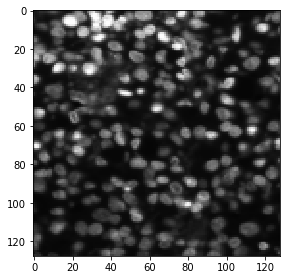

In [43]:
print("Actual Image")
imshow(np.squeeze(X_test[ix]))

Predicted Image


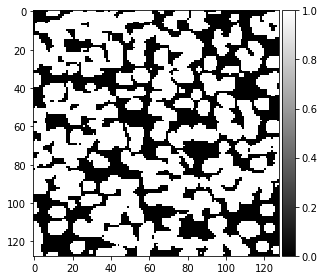

In [44]:
print("Predicted Image")
imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
plt.show()